# Analyzing Robustness Results (KSTAR)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy.stats as stats

import sys
sys.path.append('../')
import conf #This is the local config file for setting the supplements directory to your local environment

#KSTAR imports
from kstar.plot import DotPlot

odir = conf.SUPPLEMENTS_DIR+'Robustness (Fig5)/'


activities = pd.read_csv(odir + 'RESULTS/robustness_mann_whitney_activities.tsv', sep = '\t', index_col = 0)
fpr = pd.read_csv(odir + 'RESULTS/robustness_mann_whitney_fpr.tsv', sep = '\t', index_col = 0)

#create kinase dict to change kinase names to preferred 
kinase_map = pd.read_csv('../../globalKinaseMap.csv', index_col = 0)
kinase_dict = {}
for kinase in activities.index:
    kinase_dict[kinase] = kinase_map.loc[kinase,'Preferred Name']
    
# Set the column labels to  (remove the 'data:' from column names)
x_label_dict = {}
for label in activities.columns:
    l = label.replace('data:','')
    x_label_dict[label] = l
    
activities.rename(x_label_dict, inplace = True, axis = 1)
fpr.rename(x_label_dict, inplace = True, axis = 1)

#create context dataframe
cell_line = ['HCC827' for i in range(2)]+['K562' for i in range(4)]+['H3255' for i in range(3)]+['H3255']+['HCC827']
cell_type = ['NSCLC' for i in range(2)]+['CML' for i in range(4)]+['NSCLC' for i in range(5)]
context = pd.DataFrame({'Sample': activities.columns, 'Cancer Type': cell_type, 'Cell Line': cell_line})

## Dotplots

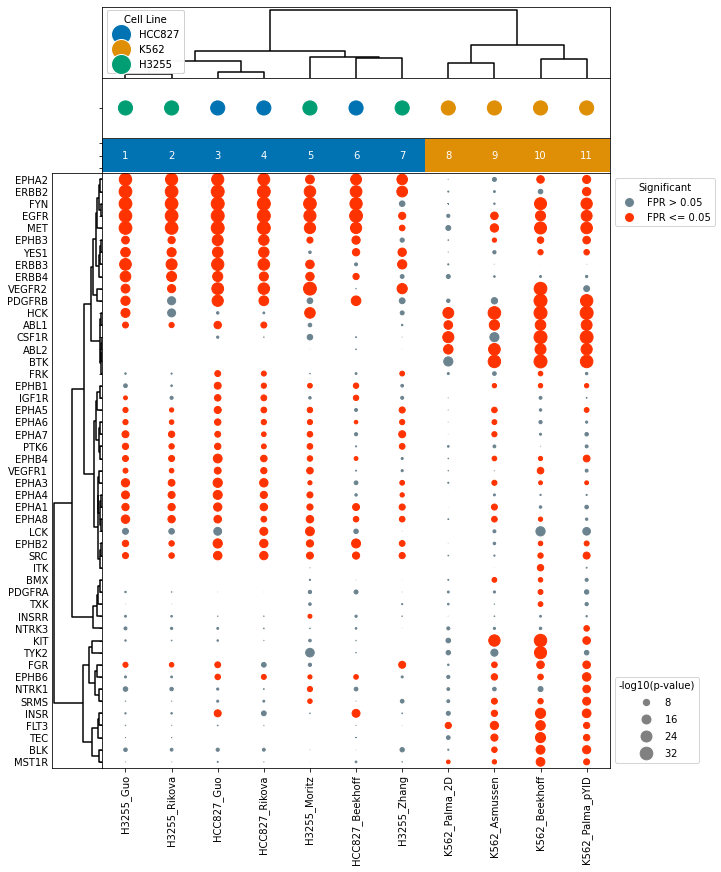

In [2]:

log_results = -np.log10(activities)

#Setup subplots so that dendrograms are included
fig, axes = plt.subplots(figsize = (10, 14), 
        nrows = 4, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[0.12,0.1,0.06, 1], 
            'width_ratios':[0.1,1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)



dots = DotPlot(log_results, 
                       fpr, 
                       legend_title='-log10(p-value)',
                      kinase_dict = kinase_dict)
#Cluster changes the sorting of the values array, so be sure to plot context last so that it is in the same sort.
dots.drop_kinases_with_no_significance()
dots.cluster(orientation = 'left', ax = axes[3,0], method='ward')
dots.cluster(orientation = 'top', ax = axes[0,1], method='ward')
dots.context(ax=axes[1,1],info = context, id_column = 'Sample', context_columns = ['Cell Line'], 
             orientation = 'top', margin = 300)

axes[0,0].axis('off')
axes[1,0].axis('off')
axes[2,0].axis('off')
axes[3,0].xaxis.set_visible(False)
axes[2,1].margins(0.05,1)

dots.dotplot(ax = axes[3,1])

#create context barplot
labels = ['NSCLC' for i in range(7)] + ['CML' for i in range(4)]
studies = ['1', '2', '3', '4', '5', '6', '7', '8', '9','10','11']
#identify unique labels and assign colors
groups = np.unique(labels)
context_colors = sns.color_palette('colorblind', len(groups))
#get xticks and bar length
ticks = axes[1,1].get_xticks()
len_bar = ticks[0]*2
color_order = list(range(len(groups)-1,-1,-1))
for lab, study,tick in zip(labels, studies, ticks):
    #decide color depending on label
    which_group = np.where(groups == lab)[0][0]
    axes[2,1].barh(0, len_bar, left = tick - len_bar/2, height = 0.25, color = context_colors[color_order[which_group]])
    axes[2,1].annotate(study, (tick, 0), ha = 'center', va = 'center', color = 'white')

[]

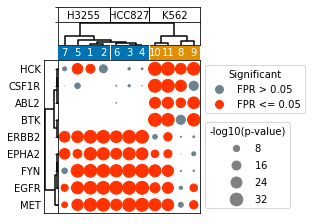

In [3]:
#Plot condensed dotplot with most differentially active kinases between CML and NSCLC
order = ['H3255_Guo', 'H3255_Rikova', 'HCC827_Guo', 'HCC827_Rikova', 'H3255_Moritz', 'HCC827_Beekhoff', 'H3255_Zhang', 'K562_Palma_2D', 'K562_Asmussen', 'K562_Beekhoff', 'K562_Palma_pYID']
kinases = ['ABL2','BTK','CSF1R','HCK','FYN','ERBB2','EPHA2','EGFR','MET']

significant = fpr.copy()
log_results = -np.log10(activities)
#restrict analysis to kinases of interest
log_results = log_results.loc[kinases,order]
significant = significant.loc[kinases,order]

fig, axes = plt.subplots(figsize = (2.8, 3.8), 
        nrows = 4, ncols = 2, 
        sharex = 'col', 
        sharey = 'row',
        gridspec_kw = {
            'height_ratios':[0.1,0.15,0.1, 1],
            'width_ratios':[0.1, 1]
        },)
fig.subplots_adjust(wspace=0, hspace=0)

dots = DotPlot(log_results, 
                       significant,
                       dotsize = 5, 
                       legend_title='-log10(p-value)')

#hierarchical clustering of both kinases and samples
dots.cluster(orientation = 'left', ax = axes[3,0], method='ward')
dots.cluster(orientation = 'top', ax = axes[1,1], method='ward')
dots.dotplot(ax = axes[3,1])
axes[1,1].set_xticklabels([])

#create context barplot
labels = ['NSCLC' for i in range(7)] + ['CML' for i in range(4)]
studies = ['1', '2', '3', '4', '5', '6', '7', '8', '9','10','11']
label_dict = {}
for i in range(len(order)):
    label_dict[order[i]] = [labels[i],studies[i]] 
#identify unique labels and assign colors
groups = np.unique(labels)
context_colors = sns.color_palette('colorblind', len(groups))
#get xticks and bar length
ticks = axes[1,1].get_xticks()
len_bar = ticks[0]*2
color_order = list(range(len(groups)-1,-1,-1))
for samp,tick in zip(dots.values.columns, ticks):
    #decide color depending on label
    which_group = np.where(groups == label_dict[samp][0])[0][0]
    axes[2,1].barh(0, len_bar, left = tick - len_bar/2, height = 0.25, color = context_colors[color_order[which_group]])
    axes[2,1].annotate(label_dict[samp][1], (tick, 0), ha = 'center', va = 'center', color = 'white',fontsize = 10)

#add cell line labels to each "group"
axes[0,1].annotate('H3255', (20,0.25), ha = 'center', fontsize = 10)
axes[0,1].annotate('HCC827', (55,0.25), ha = 'center', fontsize = 10)
axes[0,1].annotate('K562', (90,0.25), ha = 'center', fontsize = 10)
line1 = Line2D([40,40],[0,1],c = 'black', linewidth = 1)
axes[0,1].add_artist(line1)
line2 = Line2D([70,70],[0,1],c = 'black', linewidth = 1)
axes[0,1].add_artist(line2)
line3 = Line2D([40,40],[-1,0.25],c = 'white', linewidth = 1)
axes[2,1].add_artist(line3)
line4 = Line2D([70,70],[-1,0.25],c = 'white', linewidth = 1)
axes[2,1].add_artist(line4)
    
axes[0,0].axis('off')
axes[1,0].axis('off')
axes[2,0].axis('off')
axes[2,1].axis('off')
axes[1,1].set_yticks([])
axes[1,1].set_xticks([])
axes[2,0].set_xticks([])

## Assess average kinase rank across either CML or NSCLC

In [4]:

order = ['H3255_Guo', 'H3255_Rikova', 'HCC827_Guo', 'HCC827_Rikova', 'H3255_Moritz', 'HCC827_Beekhoff', 'H3255_Zhang', 'K562_Palma_2D', 'K562_Asmussen', 'K562_Beekhoff', 'K562_Palma_pYID']
results = activities[order]
#sort each column by kinase activity (most active in first row) and extract the top10 for each sample
rankings = pd.DataFrame(0, index = list(range(50)), columns = results.columns)
for col in results.columns:
    results = results.sort_values(by = col, ascending = True)
    rankings[col] = results.index
    
rankings

,H3255_Guo,H3255_Rikova,HCC827_Guo,HCC827_Rikova,H3255_Moritz,HCC827_Beekhoff,H3255_Zhang,K562_Palma_2D,K562_Asmussen,K562_Beekhoff,K562_Palma_pYID
0,MET,EGFR,FYN,FYN,KDR,EGFR,ERBB2,CSF1R,HCK,HCK,HCK
1,ERBB2,FYN,EGFR,EGFR,FYN,FYN,EPHA2,HCK,BTK,PDGFRB,CSF1R
2,FYN,ERBB2,MET,MET,EGFR,ERBB2,KDR,ABL2,ABL2,BTK,BTK
3,EGFR,MET,ERBB2,ERBB2,ERBB2,MET,ERBB3,BTK,KIT,CSF1R,PDGFRB
4,EPHA2,EPHA2,ERBB3,EPHA2,MET,EPHA2,YES1,ABL1,ABL1,KDR,MET
5,ERBB3,ERBB3,EPHA2,ERBB3,HCK,PDGFRB,EGFR,FLT3,CSF1R,KIT,FYN
6,ERBB4,ERBB4,KDR,KDR,LCK,EPHB2,EPHA7,MET,MET,TYK2,ABL2
7,YES1,YES1,PDGFRB,EPHB3,EPHA2,EPHB3,FGR,KIT,FLT3,MET,EGFR
8,PDGFRB,KDR,EPHB3,YES1,TYK2,INSR,SRC,TYK2,EGFR,FYN,ABL1
9,HCK,PDGFRB,YES1,PDGFRB,ERBB3,YES1,EPHA1,INSR,TYK2,ABL2,INSR


In [5]:
#plot average rankings for NSCLC
#get nsclc sample results
nsclc = rankings.iloc[:,0:7]
kinase = nsclc.iloc[:,0].values
averageRanks_nsclc = pd.DataFrame(0, index = kinase, columns = ['Rank'])
#calculate average rank for each kinase across all nsclc samples
start_rank = 1
for kin in averageRanks_nsclc.index:
    rank = start_rank
    for samp in nsclc.columns[1:]:
        #find rank of kinase, record
        for r in range(1,51):
            if nsclc.loc[r-1, samp] == kin:
                rank = rank + r
                break
    averageRanks_nsclc.loc[kin] = rank/nsclc.shape[1]
    start_rank = start_rank + 1 
#sort kinases by average ranking
averageRanks_nsclc = averageRanks_nsclc.sort_values(by = 'Rank')
averageRanks_nsclc

,Rank
EGFR,2.714286
ERBB2,3.000000
FYN,4.000000
MET,5.000000
EPHA2,5.142857
ERBB3,8.857143
PDGFRB,10.714286
KDR,10.714286
ERBB4,12.142857
YES1,12.428571


In [6]:
#plot average rankings for CML
#get nsclc sample results
cml = rankings.iloc[:,7:]
kinase = cml.iloc[:,0].values
averageRanks_cml = pd.DataFrame(0, index = kinase, columns = ['Rank'])
start_rank = 1
#calculate average rank for each kinase across all nsclc samples
for kin in averageRanks_cml.index:
    rank = start_rank
    for samp in cml.columns[1:]:
        #find rank of kinase, record
        for r in range(1,51):
            if cml.loc[r-1, samp] == kin:
                rank = rank + r
                break
    averageRanks_cml.loc[kin] = rank/cml.shape[1]
    start_rank = start_rank + 1 
#sort kinases by average ranking
averageRanks_cml = averageRanks_cml.sort_values(by = 'Rank')
averageRanks_cml

,Rank
HCK,1.25
BTK,3.00
CSF1R,3.25
ABL2,5.75
MET,6.75
ABL1,7.50
PDGFRB,8.25
KIT,8.75
INSR,11.50
EGFR,11.50


NameError: name 'top10' is not defined

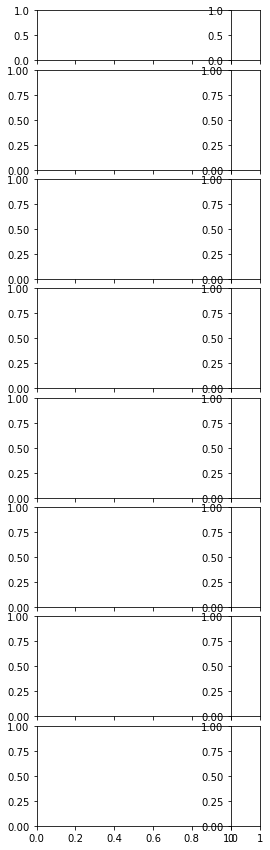

In [7]:
import seaborn as sns
cmap = sns.color_palette('colorblind')

#nsclc
fig, axes = plt.subplots(figsize = (4, 15), 
        nrows = 8, ncols = 2,
        sharex = 'col',
        gridspec_kw = { 
            'height_ratios': [0.5,1,1,1,1,1,1,1],
            'width_ratios': [1, 0.15]
        },)
fig.subplots_adjust(wspace=0, hspace=0.1)

for i in range(7):
    sample = top10.columns[i]
    kinases = top10.iloc[0:10,i]
    kinases = kinases[::-1]
    #get updated names
    new_kinases = []
    for kin in kinases:
        new_kinases.append(kinase_dict[kin])
    #plot
    bar = axes[i+1,0].barh(new_kinases, -np.log10(results.loc[kinases,sample]), color = cmap[0])
    plt.setp(axes[i+1,0].yaxis.get_majorticklabels(), fontsize = 10)
    #color bars for EGFR
    EGFR_loc = np.where(kinases == 'EGFR')[0][0]
    bar[EGFR_loc].set(color = cmap[8])


axes[7,0].set_xlabel('Activity [-log10(p)]')

axes[0,0].annotate('Non-Small Cell Lung Cancer', (16.5,0.3), ha = 'center', fontsize = 16)
axes[0,0].annotate('(NSCLC)', (16.5,0.005), ha = 'center', fontsize = 14)
axes[0,0].axis('off')

#add study labels
studies = ['(1)', '(2)', '(3)', '(4)', '(5)', '(6)', '(7)']
axes[0,1].axis('off')
for i in range(7):
    axes[i+1,1].annotate(studies[i], (0.5, 0.5), ha = 'center', va = 'center', fontsize = 14)
    axes[i+1,1].set_yticks([])
    #axes[i+1,1].axis('off')
axes[5,1].set_xticks([])

[]

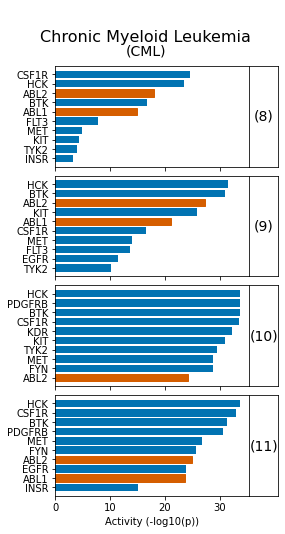

In [8]:
#cml
fig, axes = plt.subplots(figsize = (4, 9), 
        nrows = 5, ncols = 2,
        sharex = 'col',
        gridspec_kw = { 
            'height_ratios': [0.5,1,1,1,1,],
            'width_ratios': [1, 0.15]
        },)
fig.subplots_adjust(wspace=0, hspace=0.1)

top10_cml = rankings.iloc[:,7:]
for i in range(4):
    sample = top10_cml.columns[i]
    kinases = top10_cml.iloc[0:10,i]
    kinases = kinases[::-1]
    #get updated names
    new_kinases = []
    for kin in kinases:
        new_kinases.append(kinase_dict[kin])
    bar = axes[i+1,0].barh(kinases, -np.log10(results.loc[kinases,sample]), color = cmap[0])
    plt.setp(axes[i+1,0].yaxis.get_majorticklabels(), fontsize = 10)
    #color bars for ABL kinases
    ABL1_loc = np.where(kinases == 'ABL1')[0]
    #check to see if ABL1 is present in list
    if len(ABL1_loc) > 0:
        bar[ABL1_loc[0]].set(color = cmap[3])
    ABL2_loc = np.where(kinases == 'ABL2')[0]
    #check to see if ABL2 is present in list
    if len(ABL2_loc) > 0:
        bar[ABL2_loc[0]].set(color = cmap[3])
   

axes[4, 0].set_xlabel('Activity (-log10(p))')

#Add title to first axes
axes[0,0].annotate('Chronic Myeloid Leukemia', (16.5,0.3), ha = 'center', fontsize = 16)
axes[0,0].annotate('(CML)', (16.5,0.05), ha = 'center', fontsize = 14)
axes[0,0].axis('off')

#add study labels
studies = ['(8)', '(9)', '(10)', '(11)']
axes[0,1].axis('off')
for i in range(4):
    axes[i+1, 1].annotate(studies[i], (0.5, 0.5), ha = 'center', va = 'center', fontsize = 14)
    axes[i+1,1].set_yticks([])
    #axes[i+1,1].axis('off')
axes[4,1].set_xticks([])

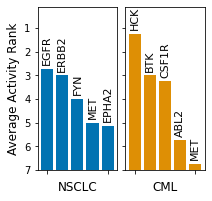

In [9]:
#plot average rankings
fig, axes = plt.subplots(figsize = (3,3),
                      nrows = 1, ncols = 2,
                        sharey = 'row')
fig.subplots_adjust(wspace = 0.1)

colors = sns.color_palette('colorblind', 2)
numKin = 5
x = np.arange(numKin)/2
ranks = averageRanks_nsclc
high = 7
bar = axes[0].bar(x,high - ranks['Rank'][0:numKin].values, bottom = ranks['Rank'][0:numKin],width = 0.4, color = colors[0])
#plot first ranking for test case
for i in range(len(x)):
    kinase = kinase_dict[ranks.index[i]]
    axes[0].annotate(kinase, (x[i], ranks.iloc[i].values[0]-0.25), ha = 'center', color = 'black',rotation = 90, fontsize = 11)

plt.yticks(range(1,8))
axes[0].set_ylabel('Average Activity Rank', fontsize = 12)
#axes[0].set_xlim([-0.2,(numKin-1)/2+0.2])
axes[0].set_xticklabels([])
axes[0].set_ylim([0.1,high])

ranks = averageRanks_cml
high = 7
bar = axes[1].bar(x,high - ranks['Rank'][0:numKin].values, bottom = ranks['Rank'][0:numKin],width = 0.4, color = colors[1])
#plot first ranking for test case
for i in range(len(x)):
    kinase = kinase_dict[ranks.index[i]]
    axes[1].annotate(kinase, (x[i], ranks.iloc[i].values[0]-0.25), ha = 'center', color = 'black',rotation = 90, fontsize = 11)

axes[1].set_xticklabels([])
axes[0].set_xlabel('NSCLC',fontsize = 12)
axes[1].set_xlabel('CML', fontsize = 12)


plt.gca().invert_yaxis()

## Jaccard Similarity between Phosphoproteomic Datasets

In [10]:
##calculate jaccard indexes using the sites found in each datases
def jaccard(list1,list2):
    """
    Calculate jaccard similarity between two lists of items
    """
    intersection = len(list(set(list1) & set(list2)))
    union = len(list(set(list1) | set(list2)))
    jaccard = float(intersection)/union
    return jaccard

def phosphositeSimilarity(evidence, setsToCompare):
    """
    Calculate the similarity between two phosphoprotoemic datasets based on the sites identified in each experiment 
    (assessed using Jaccard similarity)
    
    Parameters
    ---------
    evidence: dataframe
        binary evidence indicating whether a site was identified in a given dataset (should contain 
        KSTAR_ACCESSION and KSTAR_SITE columns)
    setsToCompare: list of 2 strings
        indicates which columns (i.e. which experiments in evidence) to compare
    """
    evidence['descriptor'] = evidence['KSTAR_ACCESSION'] + '_' + evidence['KSTAR_SITE']
    #add 'data:' to front of columns so that it can be recognized
    setsToCompare = ['data:'+setsToCompare[i] for i in range(len(setsToCompare))]
    set1 = evidence[evidence[setsToCompare[0]] == 1]['descriptor'].values
    set2 = evidence[evidence[setsToCompare[1]] == 1]['descriptor'].values
    similarity = jaccard(set1,set2)
    return similarity
    
def makeTableComp_Jac(evidence, order = None):
    """
    Compare all similarlity between all experiments present in evidence (finds experiment columns based on 'data:' being
    present in column name)
    """
    #Use order given in evidence unless order parameter is given
    if order is not None:
        table = pd.DataFrame(None, columns = order, index = order)
    else:
        renamed_columns = [col.split(':')[1] for col in evidence.columns if 'data:' in col]
        table = pd.DataFrame(None, columns = renamed_columns, index = renamed_columns)
        
    for i in range(table.shape[0]-1):
        for j in range(i+1, table.shape[0]):
            set1 = table.columns[i]
            set2 = table.columns[j]
            setsToCompare = [set1,set2]
            similarity = phosphositeSimilarity(evidence,setsToCompare)
            #removeDataName from sets
            table.loc[set1,set2] = similarity
            table.loc[set2,set1] = similarity
            
    for i in range(table.shape[1]):
        table.iloc[i,i] = 1

    
    return table

import matplotlib.patches as patches
def similarityHeatMap(similarity, labels = None, studies = None, significance = None, annot = None, legend_title = None, colorbar_label = 'Jaccard Similarity', context_colors = None, context_gap = 0, cmap = 'coolwarm', vmin = -1, vmax = 1,figsize = 10):
    """
    Plot triangle heatmap indicating the similarity between each study (either based on phosphosites identified or predicted 
    kinase activity).
    
    Parameters
    ----------
    similarity: pandas dataframe
        symmetric matrix indicating the similarity between all datasets (either jaccard similarity or spearmans rank)
    labels: list of length equal to number of experiments in similarity
        descriptive category to indicate coloring of bars (in this case, NSCLC vs. CML)
    studies: list of length equal to number of experiments in similarity
        indicates the name (or identifier) for each experiment to label on context barplots
    significance: pandas dataframe
        Provides significance (p-values) for each similarity value. If annot = 'Sig', must be included. Otherwise, does not affect
        plot
    annot: string
        Type of annotation to include on plot. 
            'Value': In each heatmap cell, also include the actual similarity value, in addition to color coding
            'Sig': In each heatmap cell, include both similarity value and signicance ('*' -> p<0.05)
            None: No annotation, just color coding
    """
    fig = plt.subplots(figsize = (figsize,figsize))
    size = (similarity.shape[0] + 2)*2
    #heatmap subplot
    ax1 = plt.subplot2grid((size,size+1), (0,2), rowspan = similarity.shape[0]*2+2, colspan = similarity.shape[1]*2+2)
    #colorbar subplot
    ax2 = plt.subplot2grid((size,size+1), (0,size), rowspan = similarity.shape[0]*2+2, colspan = 1)
    #context bars subplot
    ax3 = plt.subplot2grid((size,size+1), (0,0), rowspan = similarity.shape[0]*2+2, colspan = 2)
    #context bars subplot
    ax4 = plt.subplot2grid((size,size+1), (size-2,2), rowspan = 2, colspan = similarity.shape[0]*2+2)
    
    #Plot heatmap and colorbar
    #Create triangle matrix of booleans
    triangle = np.tril(np.ones(similarity.shape)).astype(np.bool)
    ##### 3 possible annotation options #######
    #1) In each cell indicate the value of similaritu
    if annot == 'Value':
        tri_df = similarity.where(triangle)
        heat = sns.heatmap(tri_df.astype(float), ax = ax1, cmap = cmap, vmin = vmin, vmax = vmax, annot = True, 
                           linewidths = 0.5, cbar_kws={'label': colorbar_label}, xticklabels = False, yticklabels = False, 
                           cbar_ax = ax2, annot_kws = {'size':7})
    # 2) In each cell indicate the value of similarity and whether it is significant (* -> p < 0.05)
    elif annot == 'Sig':
        #force to float if not already
        significance = significance.astype(float)
        vals = np.array([[str(round(similarity.iloc[i,j],2)) for j in range(similarity.shape[0])] for i in range(similarity.shape[1])])
        sig = np.array([[vals[i,j]+'*' if significance.iloc[i,j] < 0.05 else vals[i,j]+'' for j in range(significance.shape[1])] 
                        for i in range(significance.shape[0])])
        tri_df = similarity.where(triangle)
        heat = sns.heatmap(tri_df.astype(float), ax = ax1, cmap = cmap, vmin = vmin, vmax = vmax, annot = sig, fmt = '',
                           linewidths = 0.5, cbar_kws={'label': colorbar_label}, annot_kws = {'size':7},
                           xticklabels = False, yticklabels = False, cbar_ax = ax2)
        ax2.yaxis.label.set_size(10)
    # 3) Don't annotate
    else:
        tri_df = tab_r.where(triangle)
        heat = sns.heatmap(tri_df.astype(float), ax = ax1, cmap = cmap, vmin = vmin, vmax = vmax,linewidths = 0.5, xticklabels = False, yticklabels = False, cbar_ax = ax2)
        
    #create context barplot
    #identify unique labels and assign colors
    groups = np.unique(labels)
    if context_colors is None:
        context_colors = sns.color_palette('colorblind', len(groups))

    top = True
    #determine the starting bottom position and the length of the bars needed
    bottom = similarity.shape[0]+1
    len_bar = bottom/similarity.shape[0]
    color_order = list(range(len(groups)-1,-1,-1))
    for lab, study in zip(labels, studies):
        #make first bar white/invisible since triangle barplot doesn't have anything on top
        bottom = bottom - len_bar
        #decide color depending on label
        which_group = np.where(groups == lab)[0][0]
        ax3.bar(0,len_bar-context_gap, bottom = bottom+context_gap, width = 0.2, color = context_colors[color_order[which_group]])
        ax3.annotate(study, (0,bottom+len_bar/2), ha = 'center', va = 'center', color = 'white',fontsize = 10)
            
    #bottom context bars need to be plotted in opposite order, but does similar as above
    top = True
    bottom = similarity.shape[0]+1
    for lab, study in zip(labels[::-1], studies[::-1]):
        #make first bar white/invisible since triangle barplot doesn't have anything on top
        bottom = bottom - len_bar
        #decide color depending on label
        which_group = np.where(groups == lab)[0][0]
        ax4.barh(0, len_bar-context_gap, left = bottom+context_gap, height = 0.3, color = context_colors[color_order[which_group]])
        ax4.annotate(study, (bottom+len_bar/2, 0), ha = 'center', va = 'center', color = 'white',fontsize = 10)

    
    # surround samples from the same study with boxes
    xy_list = [(0,2),(1,3),(5,9),(7,10)]
    for xy in xy_list:
        rect = patches.Rectangle(xy,0.98,0.98, fill = False, ec = 'black', lw = 1.5)
        ax1.add_artist(rect)
    #housekeeping
    ax3.axis('off')
    ax3.set_yticks([])
    ax3.set_xticks([])
    ax3.set_ylim([0,similarity.shape[0]+1])
    ax4.axis('off')
    ax4.set_yticks([])
    ax4.set_xticks([])
    ax4.set_xlim([0,similarity.shape[0]+1])

In [11]:
#load binarized experiments (indicates whether is present in experiment)
### Comb HCC827 and H3255
bin_Comb = pd.read_csv(odir + 'RESULTS/OncoLung/binary_experiment/OncoLung_binarized_experiment.tsv', sep = '\t')
#extract only columns
bin_Comb = bin_Comb[['KSTAR_ACCESSION', 'KSTAR_SITE','data:H3255','data:HCC827']]
bin_Comb = bin_Comb.iloc[np.where(((bin_Comb['data:H3255'] + bin_Comb['data:HCC827']) > 0))[0]]

#combined data
bin_K562 = pd.read_csv(odir + 'RESULTS/combined/combined_Y_binarized_experiment.tsv', sep = '\t', index_col = 0)
#extract other K562 binary evidence
bin_CML = pd.read_csv(odir + 'RESULTS/BCR-ABL/BCR-ABL_y_binarized_experiment.tsv', sep = '\t', index_col = 0).rename(columns = {'data:treated_to_untreated:pre-treatment':'data:K562 CML'})
data_cols_to_remove = [col for col in bin_CML.columns if 'treated_to_untreated' in col]
bin_CML.drop(data_cols_to_remove, inplace = True, axis = 1)
#H3255 samples
bin_H3255 = pd.read_csv(odir + 'RESULTS/All_H3255/All_H3255_Y_binarized_experiment.tsv', sep = '\t', index_col = 0)

#merge all datasets into a single dataframe
binary = pd.merge(bin_K562,bin_CML, how = 'outer', on =['KSTAR_ACCESSION','KSTAR_SITE'])
binary = pd.merge(binary,bin_H3255, how = 'outer', on =['KSTAR_ACCESSION','KSTAR_SITE'])
binary = pd.merge(binary, bin_Comb, how = 'outer', on =['KSTAR_ACCESSION','KSTAR_SITE'])

In [13]:
order = ['H3255 Guo', 'H3255', 'HCC827 Guo', 'HCC827', 'H3255_Moritz', 'HCC827 INKA', 'H3255_Zhang', 'K562 Palma_2D', 'K562 CML', 'K562 INKA', 'K562 Palma_pYID']
#calculate the site similarity between all experiments present in the robustness dataset
siteJac = makeTableComp_Jac(binary, order = order)
siteJac

,H3255 Guo,H3255,HCC827 Guo,HCC827,H3255_Moritz,HCC827 INKA,H3255_Zhang,K562 Palma_2D,K562 CML,K562 INKA,K562 Palma_pYID
H3255 Guo,1,0.876333,0.445131,0.379095,0.10971,0.107402,0.210721,0.034314,0.092334,0.096282,0.109799
H3255,0.876333,1,0.381847,0.388982,0.104,0.096491,0.201195,0.0375,0.095238,0.089237,0.1052
HCC827 Guo,0.445131,0.381847,1,0.863445,0.110692,0.12606,0.177102,0.03752,0.097561,0.108579,0.123508
HCC827,0.379095,0.388982,0.863445,1,0.103448,0.116314,0.169557,0.039076,0.098672,0.098698,0.114355
H3255_Moritz,0.10971,0.104,0.110692,0.103448,1,0.053371,0.086486,0.017513,0.030466,0.044415,0.038636
HCC827 INKA,0.107402,0.096491,0.12606,0.116314,0.053371,1,0.057949,0.021521,0.036995,0.201721,0.183782
H3255_Zhang,0.210721,0.201195,0.177102,0.169557,0.086486,0.057949,1,0.069069,0.100629,0.08189,0.064409
K562 Palma_2D,0.034314,0.0375,0.03752,0.039076,0.017513,0.021521,0.069069,1,0.142857,0.049689,0.054
K562 CML,0.092334,0.095238,0.097561,0.098672,0.030466,0.036995,0.100629,0.142857,1,0.106908,0.092991
K562 INKA,0.096282,0.089237,0.108579,0.098698,0.044415,0.201721,0.08189,0.049689,0.106908,1,0.30015


C:\Users\Sam\AppData\Local\Temp/ipykernel_43060/3352692730.py:96: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  triangle = np.tril(np.ones(similarity.shape)).astype(np.bool)


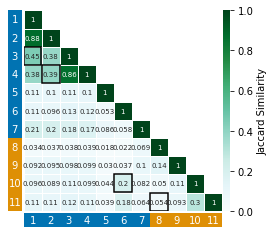

In [14]:
label_cancerType = ['NSCLC' for i in range(7)] + ['CML' for i in range(4)]
label_number = ['1', '2', '3', '4', '5', '6', '7', '8', '9','10','11']
similarityHeatMap(siteJac, label_cancerType, label_number, legend_title = 'Dataset # and Cancer Type', context_gap = 0, cmap = 'BuGn', vmin = 0, vmax = 1, annot = 'Value',figsize=4)

## Spearman Rank Correlation between Kinase Activity Profiles

In [15]:
import scipy.stats as stats

def makeTableComp_Corr(evidence, order = None):
    """
    Calculate rank correlations between kinase activity profiles obtained from each experiment (both r and p)
    """
    #find data columns
    if order is not None:
        evidence = evidence[order
                           ]
    data_columns = evidence.columns
    #Make table to store both the correlation and p-value
    table_r = pd.DataFrame(None, columns = data_columns, index = data_columns)
    table_p = pd.DataFrame(None, columns = data_columns, index = data_columns)
    for i in range(len(data_columns)-1):
        for j in range(i+1, len(data_columns)):
            set1 = data_columns[i]
            set2 = data_columns[j] 
            similarity, p = stats.spearmanr(evidence[set1],evidence[set2])
            table_r.loc[set1,set2] = similarity
            table_r.loc[set2,set1] = similarity
            table_p.loc[set1,set2] = p
            table_p.loc[set2,set1] = p
            
    for i in range(len(data_columns)):
        table_r.iloc[i,i] = 1
        table_p.iloc[i,i] = 1
    return table_r, table_p

In [17]:
#rearrange the table
order = ['H3255_Guo', 'H3255_Rikova', 'HCC827_Guo', 'HCC827_Rikova', 'H3255_Moritz', 'HCC827_Beekhoff', 'H3255_Zhang', 'K562_Palma_2D', 'K562_Asmussen', 'K562_Beekhoff', 'K562_Palma_pYID']
results = activities[order]
kstar_r, kstar_p = makeTableComp_Corr(results, order = order)
kstar_r

,H3255_Guo,H3255_Rikova,HCC827_Guo,HCC827_Rikova,H3255_Moritz,HCC827_Beekhoff,H3255_Zhang,K562_Palma_2D,K562_Asmussen,K562_Beekhoff,K562_Palma_pYID
H3255_Guo,1,0.993781,0.916709,0.911953,0.774568,0.699801,0.814901,-0.252491,-0.180701,-0.181613,0.102043
H3255_Rikova,0.993781,1,0.922201,0.920399,0.780723,0.698699,0.803602,-0.257264,-0.184363,-0.154493,0.124334
HCC827_Guo,0.916709,0.922201,1,0.988259,0.734934,0.780168,0.792912,-0.288355,-0.202785,-0.116831,0.142953
HCC827_Rikova,0.911953,0.920399,0.988259,1,0.730006,0.775145,0.789858,-0.317463,-0.242167,-0.132584,0.127206
H3255_Moritz,0.774568,0.780723,0.734934,0.730006,1,0.566675,0.596221,-0.232173,-0.166771,-0.0206,0.133061
HCC827_Beekhoff,0.699801,0.698699,0.780168,0.775145,0.566675,1,0.557805,-0.258007,-0.164274,-0.192989,0.127491
H3255_Zhang,0.814901,0.803602,0.792912,0.789858,0.596221,0.557805,1,-0.30565,-0.185118,-0.245912,0.013398
K562_Palma_2D,-0.252491,-0.257264,-0.288355,-0.317463,-0.232173,-0.258007,-0.30565,1,0.66886,0.471212,0.52413
K562_Asmussen,-0.180701,-0.184363,-0.202785,-0.242167,-0.166771,-0.164274,-0.185118,0.66886,1,0.525666,0.622761
K562_Beekhoff,-0.181613,-0.154493,-0.116831,-0.132584,-0.0206,-0.192989,-0.245912,0.471212,0.525666,1,0.748475


C:\Users\Sam\AppData\Local\Temp/ipykernel_43060/3352692730.py:96: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  triangle = np.tril(np.ones(similarity.shape)).astype(np.bool)


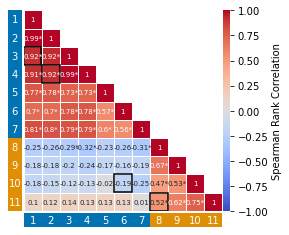

In [18]:
label_cancerType = ['NSCLC' for i in range(7)] + ['CML' for i in range(4)]
label_number = ['1', '2', '3', '4', '5', '6', '7', '8', '9','10','11']
similarityHeatMap(kstar_r, label_cancerType, label_number, kstar_p, legend_title = 'Dataset # and Cancer Type', colorbar_label = 'Spearman Rank Correlation', context_gap = 0, cmap = 'coolwarm', vmin = -1, vmax = 1, annot = 'Sig',figsize=4)

## Spearman Rank Correlation for KEA3 Mean Ranks

In [19]:
#load results from kea3
kea3 = pd.read_csv(odir + 'KEA3_robustness_results.tsv', sep =  '\t')

#extract mean ranks for each dataset
rearranged = pd.DataFrame(None, columns = kea3['Query Name'].unique(), index = kea3['TF'].unique())
for exp in kea3['Query Name'].unique():
    tmp = kea3[kea3['Query Name'] == exp]
    tmp.index = tmp['TF']
    rearranged.loc[tmp.index, exp] = tmp['Score']

rearranged = rearranged.astype(float)

#rename some of the columns who don't have very helpful names
col_dict = {'data:HCC827 INKA':'data:HCC827_Beekhoff',
            'data:HCC827 Guo':'data:HCC827_Guo' ,
            'data:HCC827':'data:HCC827_Rikova',
            'data:H3255': 'data:H3255_Rikova',
            'data:H3255 Guo':'data:H3255_Guo',
            'data:H3255_Moritz':'data:H3255_Moritz',
            'data:H3255_Zhang':'data:H3255_Zhang', 
            'data:treated_to_untreated:pre-treatment':'data:K562_Asmussen',
            'data:K562 INKA':'data:K562_Beekhoff',
            'data:K562 Palma_pYID':'data:K562_Palma_pYID',
            'data:K562 Palma_2D':'data:K562_Palma_2D'}
rearranged.rename(col_dict, axis = 1, inplace = True)

In [20]:
#rearrange the table
order = ['data:HCC827_Beekhoff','data:HCC827_Guo','data:HCC827_Rikova','data:H3255_Rikova','data:H3255_Guo','data:H3255_Moritz',
            'data:H3255_Zhang', 'data:K562_Asmussen','data:K562_Beekhoff','data:K562_Palma_pYID','data:K562_Palma_2D']
results = rearranged[order]
kea3_r, kea3_p = makeTableComp_Corr(results, order = order)
kea3_r

,data:HCC827_Beekhoff,data:HCC827_Guo,data:HCC827_Rikova,data:H3255_Rikova,data:H3255_Guo,data:H3255_Moritz,data:H3255_Zhang,data:K562_Asmussen,data:K562_Beekhoff,data:K562_Palma_pYID,data:K562_Palma_2D
data:HCC827_Beekhoff,1,0.877072,0.879738,0.887484,0.885904,0.843076,0.869216,0.871367,0.945163,0.949131,0.877521
data:HCC827_Guo,0.877072,1,0.997562,0.971242,0.974281,0.926676,0.946489,0.86738,0.880618,0.86634,0.826584
data:HCC827_Rikova,0.879738,0.997562,1,0.974367,0.972173,0.921864,0.949715,0.868387,0.880567,0.865974,0.827514
data:H3255_Rikova,0.887484,0.971242,0.974367,1,0.995887,0.901353,0.957952,0.844738,0.877313,0.863691,0.820761
data:H3255_Guo,0.885904,0.974281,0.972173,0.995887,1,0.907494,0.9561,0.847763,0.879505,0.866701,0.82142
data:H3255_Moritz,0.843076,0.926676,0.921864,0.901353,0.907494,1,0.890583,0.841924,0.848475,0.826951,0.758933
data:H3255_Zhang,0.869216,0.946489,0.949715,0.957952,0.9561,0.890583,1,0.856771,0.874175,0.858764,0.848008
data:K562_Asmussen,0.871367,0.86738,0.868387,0.844738,0.847763,0.841924,0.856771,1,0.90204,0.896089,0.853971
data:K562_Beekhoff,0.945163,0.880618,0.880567,0.877313,0.879505,0.848475,0.874175,0.90204,1,0.975441,0.907622
data:K562_Palma_pYID,0.949131,0.86634,0.865974,0.863691,0.866701,0.826951,0.858764,0.896089,0.975441,1,0.920203


C:\Users\Sam\AppData\Local\Temp/ipykernel_43060/3352692730.py:96: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  triangle = np.tril(np.ones(similarity.shape)).astype(np.bool)


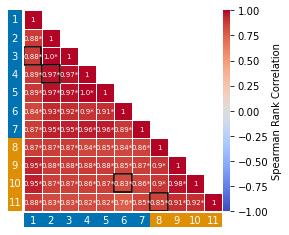

In [21]:
label_cancerType = ['NSCLC' for i in range(7)] + ['CML' for i in range(4)]
label_number = ['1', '2', '3', '4', '5', '6', '7', '8', '9','10','11']
similarityHeatMap(kea3_r, label_cancerType, label_number, kea3_p, legend_title = 'Dataset # and Cancer Type', colorbar_label = 'Spearman Rank Correlation', context_gap = 0, cmap = 'coolwarm', vmin = -1, vmax = 1, annot = 'Sig',figsize=4)

##### compare to KSTAR results

In [22]:
#extract kstar correlations (avoiding repeats)
melted_KSTAR = pd.DataFrame(np.tril(kstar_r), index = kstar_r.index, columns = kea3_r.columns).replace(0,np.nan).melt(ignore_index= False).dropna()
melted_KSTAR['Method'] = 'KSTAR'
#extract kea3 correlations (avoiding repeats)
melted_KEA3 = pd.DataFrame(np.tril(kea3_r), index = kea3_r.index, columns = kea3_r.columns).replace(0,np.nan).melt(ignore_index= False).dropna()
melted_KEA3['Method'] = 'KEA3'
#combine and rename columns
melted = pd.concat([melted_KSTAR, melted_KEA3])
melted.rename({'variable':'Study','value':'Spearman Correlation'}, inplace = True, axis = 1)


#add column indicating comparison type (within tissue (NSCLC vs. NSCLC or CML vs. CML) or between tissue (CML vs. CML))
comp = []
for i in range(melted.shape[0]):
    cell1 = 'H3255' in melted.index[i] or 'HCC827' in melted.index[i]
    cell2 = 'H3255' in melted.iloc[i,0] or 'HCC827' in melted.iloc[i,0]
    diff = melted.iloc[i,1] != 1
    if diff:
        if (cell1 and cell2) or (not cell1 and not cell2):
            comp.append('Within Tissues')
        else:
            comp.append('Between Tissues')
    else:
        comp.append(None)
melted['Comparison Type'] = comp

C:\Users\Sam\miniconda3\envs\kstar\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 29.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\Sam\miniconda3\envs\kstar\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 46.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


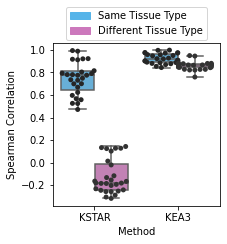

In [23]:
plt.figure(figsize = (3,3))
pal = sns.color_palette('colorblind')
with_col = pal[-1]
bet_col = pal[4]
palette = {'Within Tissues':with_col, 'Between Tissues':bet_col}
swarm = sns.swarmplot(x="Method", y="Spearman Correlation", hue = 'Comparison Type', data=melted, dodge = True,  color=".2")
box = sns.boxplot(x="Method", y="Spearman Correlation", hue = 'Comparison Type', data=melted, whis=np.inf, palette = palette)
#for i in range(0,4):
#    mybox = ax.artists[i]
#    mybox.set_facecolor(colors[i])
swarm.legend_.remove()

#create legend
patch1 = patches.Patch(color=with_col, label='Same Tissue Type')
patch2 = patches.Patch(color=bet_col, label='Different Tissue Type')
plt.legend(handles=[patch1,patch2], bbox_to_anchor = (0.95,1.25))